In [1]:
"""Load combined diffusion-relaxometry data and mask"""

# Access the data
from os.path import expanduser, join
home = expanduser('~')
dname = join(home, 'brain-data-neil')

fdwi = join(dname, 'cdmri11_r.nii') # nifti file with whole-brain MRI data
mask = join(dname, 'vol0083_brain_mask.nii.gz') # brain mask
fbval = join(dname, 'parameters_new_bval.txt') # list of b-values
fbvec = join(dname, 'parameters_new_bvec2.txt') # list of b-vectors

# Load dMRI datasets using Dipy
from dipy.io.image import load_nifti
data, affine, img = load_nifti(fdwi, return_img=True)
mask_data, affine1, img1 = load_nifti(mask, return_img=True)

# Check size of data --> (77, 92, 56, 1344)
print(data.shape)

(77, 92, 56, 1344)


In [2]:
"""Set up acquisition scheme using b-values, b-vectors, TI, TE"""

# Import relevant modules
from os.path import join
import numpy as np
from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues

# Load parameters and convert to SI units
bvalues = np.loadtxt(join('parameters_new_bval.txt'))  # given in s/m^2
bvalues_SI = bvalues * 1e6 # now given in SI units as s/mm^2
gradient_directions = np.loadtxt(join('parameters_new_bvec.txt'))
delta = 0.0242 # time in seconds
Delta = 0.0391 # time in seconds
grad_echo_inv = np.loadtxt(join('parameters_new.txt'))
TE = grad_echo_inv[:,5]/1e3
TI = grad_echo_inv[:,4]/1e3

# Acquisition scheme
acq_scheme = acquisition_scheme_from_bvalues(bvalues_SI, gradient_directions, delta, Delta, TE, TI)
acq_scheme.print_acquisition_info

Acquisition scheme summary

total number of measurements: 1344
number of b0 measurements: 84
number of DWI shells: 12

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms] |TI[ms]
0           |28        |0               |0                        |24.2       |39.1      |80.0 	|1059.7
1           |28        |500             |19                       |24.2       |39.1      |80.0 	|883.12
2           |84        |1000            |27                       |24.2       |39.1      |80.0 	|176.62
3           |140       |2000            |39                       |24.2       |39.1      |80.0 	|529.87
4           |168       |3000            |48                       |24.2       |39.1      |80.0 	|20.0 
5           |28        |0               |0                        |24.2       |39.1      |105.0	|1059.7
6           |28        |500             |19                       |24.2       |39.1      |105.0	|883.12
7           |84        |1000            |27      

In [6]:
"""Create RELAXED ball & stick model using modified Dmipy code

This model will be fitted to all voxels of the MRI data using Dmipy's least squares approach.
"""

# Import relevant modules
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

# Initiate RELAXED ball and stick model
stick = cylinder_models.C1StickRelaxed()
ball = gaussian_models.G1BallRelaxed()
relaxed_BAS = MultiCompartmentModel(models=[ball, stick])

# Display parameters for model
print(relaxed_BAS.parameter_cardinality)

# Set initial guesses for certain parameters to speed up processing
relaxed_BAS.set_initial_guess_parameter('G1BallRelaxed_1_t2', 0.120)
relaxed_BAS.set_initial_guess_parameter('G1BallRelaxed_1_t1', 3)
relaxed_BAS.set_initial_guess_parameter('C1StickRelaxed_1_t2', 0.080)
relaxed_BAS.set_initial_guess_parameter('C1StickRelaxed_1_t1', 2)
relaxed_BAS.set_initial_guess_parameter('G1BallRelaxed_1_lambda_iso', 1e-09)
relaxed_BAS.set_initial_guess_parameter('C1StickRelaxed_1_lambda_par', 2.2e-09)

OrderedDict([('G1BallRelaxed_1_lambda_iso', 1), ('G1BallRelaxed_1_t2', 1), ('G1BallRelaxed_1_t1', 1), ('C1StickRelaxed_1_mu', 2), ('C1StickRelaxed_1_lambda_par', 1), ('C1StickRelaxed_1_t2', 1), ('C1StickRelaxed_1_t1', 1), ('partial_volume_0', 1), ('partial_volume_1', 1)])


In [ ]:
"""Ball T2"""

import numpy as np
import time
start_time = time.time()

# print(data.shape[0:2], 2)
t2_ball = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(data.shape[0]):
    for y in range(data.shape[1]):
        if mask_data[x,y,28] > 0:
            fitted_BAS = relaxed_BAS.fit(acq_scheme, data[x,y,30,:])
            print(fitted_BAS.fitted_parameters['G1BallRelaxed_1_t2'])
            t2_ball[x,y,:] = fitted_BAS.fitted_parameters['G1BallRelaxed_1_t2']
            print((x, y))
            
print(t2_ball)

In [8]:
# Calculate time taken for prediction
print("Prediction time: %s seconds" % (time.time() - start_time))

Prediction time: 1193.710382938385 seconds


In [8]:
# # Save ball t2 as a nifti file
# from dipy.io.image import save_nifti
# save_nifti('relaxed_ball_t2.nii.gz', t2_ball, affine)

In [ ]:
"""Ball T1"""

import numpy as np
import time
start_time = time.time()

# print(data.shape[0:2], 2)
t1_ball = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(data.shape[0]):
    for y in range(data.shape[1]):
        if mask_data[x,y,28] > 0:
            fitted_BAS = relaxed_BAS.fit(acq_scheme, data[x,y,30,:])
            print(fitted_BAS.fitted_parameters['G1BallRelaxed_1_t1'])
            t1_ball[x,y,:] = fitted_BAS.fitted_parameters['G1BallRelaxed_1_t1']
            print((x, y))
            
print(t1_ball)

In [11]:
# Calculate time taken for prediction
print("Prediction time: %s seconds" % (time.time() - start_time))

Prediction time: 1181.3834710121155 seconds


In [12]:
# # Save ball t1 as a nifti file
# from dipy.io.image import save_nifti
# save_nifti('relaxed_ball_t1.nii.gz', t1_ball, affine)

In [ ]:
"""Stick T2"""

import numpy as np
import time
start_time = time.time()

# print(data.shape[0:2], 2)
t2_stick = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(data.shape[0]):
    for y in range(data.shape[1]):
        if mask_data[x,y,28] > 0:
            fitted_BAS = relaxed_BAS.fit(acq_scheme, data[x,y,30,:])
            print(fitted_BAS.fitted_parameters['C1StickRelaxed_1_t2'])
            t2_stick[x,y,:] = fitted_BAS.fitted_parameters['C1StickRelaxed_1_t2']
            print((x, y))
            
print(t2_stick)

In [15]:
# Calculate time taken for prediction
print("Prediction time: %s seconds" % (time.time() - start_time))

Prediction time: 1180.5765209197998 seconds


In [16]:
# # Save stick t2 as a nifti file
# from dipy.io.image import save_nifti
# save_nifti('relaxed_stick_t2.nii.gz', t2_stick, affine)

In [ ]:
"""Stick T1"""

import numpy as np
import time
start_time = time.time()

# print(data.shape[0:2], 2)
t1_stick = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(data.shape[0]):
    for y in range(data.shape[1]):
        if mask_data[x,y,28] > 0:
            fitted_BAS = relaxed_BAS.fit(acq_scheme, data[x,y,30,:])
            print(fitted_BAS.fitted_parameters['C1StickRelaxed_1_t1'])
            t1_stick[x,y,:] = fitted_BAS.fitted_parameters['C1StickRelaxed_1_t1']
            print((x, y))
            
print(t1_stick)

In [18]:
# Calculate time taken for prediction
print("Prediction time: %s seconds" % (time.time() - start_time))

Prediction time: 1177.9483358860016 seconds


In [19]:
# # Save stick t1 as a nifti file
# from dipy.io.image import save_nifti
# save_nifti('relaxed_stick_t1.nii.gz', t1_stick, affine)

In [ ]:
"""Ball volume fraction"""

import numpy as np
import time
start_time = time.time()

# print(data.shape[0:2], 2)
part_vol_zero = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(data.shape[0]):
    for y in range(data.shape[1]):
        if mask_data[x,y,28] > 0:
            fitted_BAS = relaxed_BAS.fit(acq_scheme, data[x,y,28,:])
            print(fitted_BAS.fitted_parameters['partial_volume_0'])
            part_vol_zero[x,y,:] = fitted_BAS.fitted_parameters['partial_volume_0']
            print((x, y))
            
print(part_vol_zero)

In [22]:
# Calculate time taken for prediction
print("Prediction time: %s seconds" % (time.time() - start_time))

Prediction time: 1201.9825360774994 seconds


In [23]:
# # Save ball volume fraction as a nifti file
# from dipy.io.image import save_nifti
# save_nifti('relaxed_part_vol_zero.nii.gz', part_vol_zero, affine)

In [ ]:
"""Stick volume fraction"""

import numpy as np
import time
start_time = time.time()

# print(data.shape[0:2], 2)
part_vol_one = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(data.shape[0]):
    for y in range(data.shape[1]):
        if mask_data[x,y,28] > 0:
            fitted_BAS = relaxed_BAS.fit(acq_scheme, data[x,y,28,:])
            print(fitted_BAS.fitted_parameters['partial_volume_1'])
            part_vol_one[x,y,:] = fitted_BAS.fitted_parameters['partial_volume_1']
            print((x, y))
            
print(part_vol_one)

In [25]:
# Calculate time taken for prediction
print("Prediction time: %s seconds" % (time.time() - start_time))

Prediction time: 1180.0361561775208 seconds


In [26]:
# # Save stick volume fraction as a nifti file
# from dipy.io.image import save_nifti
# save_nifti('relaxed_part_vol_one.nii.gz', part_vol_one, affine)

In [ ]:
"""Ball diffusivity"""

import numpy as np
import time
start_time = time.time()

# print(data.shape[0:2], 2)
l_iso = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(data.shape[0]):
    for y in range(data.shape[1]):
        if mask_data[x,y,28] > 0:
            fitted_BAS = relaxed_BAS.fit(acq_scheme, data[x,y,28,:])
            print(fitted_BAS.fitted_parameters['G1BallRelaxed_1_lambda_iso'])
            l_iso[x,y,:] = fitted_BAS.fitted_parameters['G1BallRelaxed_1_lambda_iso']
            print((x, y))
            
print(l_iso)

In [29]:
# Calculate time taken for prediction
print("Prediction time: %s seconds" % (time.time() - start_time))

Prediction time: 1174.1077971458435 seconds


In [30]:
# # Save ball diffusivity as a nifti file
# from dipy.io.image import save_nifti
# save_nifti('relaxed_ball_lambda_iso.nii.gz', l_iso, affine)

In [ ]:
"""Stick fibre direction"""

import numpy as np
import time
start_time = time.time()

# print(data.shape[0:2], 2)
mu = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(data.shape[0]):
    for y in range(data.shape[1]):
        if mask_data[x,y,28] > 0:
            fitted_BAS = relaxed_BAS.fit(acq_scheme, data[x,y,28,:])
            print(fitted_BAS.fitted_parameters['C1StickRelaxed_1_mu'])
            mu[x,y,:] = fitted_BAS.fitted_parameters['C1StickRelaxed_1_mu']
            print((x, y))
            
print(mu)

In [32]:
# Calculate time taken for prediction
print("Prediction time: %s seconds" % (time.time() - start_time))

Prediction time: 1181.9787108898163 seconds


In [33]:
# # Save stick fibre direction as a nifti file
# from dipy.io.image import save_nifti
# save_nifti('relaxed_stick_mu.nii.gz', mu, affine)

In [ ]:
"""Stick axial diffusivity"""

import numpy as np
import time
start_time = time.time()

# print(data.shape[0:2], 2)
l_par = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(data.shape[0]):
    for y in range(data.shape[1]):
        if mask_data[x,y,28] > 0:
            fitted_BAS = relaxed_BAS.fit(acq_scheme, data[x,y,28,:])
            print(fitted_BAS.fitted_parameters['C1StickRelaxed_1_lambda_par'])
            l_par[x,y,:] = fitted_BAS.fitted_parameters['C1StickRelaxed_1_lambda_par']
            print((x, y))
            
print(l_par)

In [35]:
# Calculate time taken for prediction
print("Prediction time: %s seconds" % (time.time() - start_time))

Prediction time: 1183.3236231803894 seconds


In [27]:
# # Save stick axial diffusivity as a nifti file to view on FSLeyes
# from dipy.io.image import save_nifti
# save_nifti('relaxed_stick_lambda_par.nii.gz', l_par, affine)

In [39]:
# Save predicted arrays as numpy array files
# np.save("relaxed_t2_ball", t2_ball)
# np.save("relaxed_t1_ball", t1_ball)
# np.save("relaxed_t2_stick", t2_stick)
# np.save("relaxed_t1_stick", t1_stick)
# np.save("relaxed_vol_zero", part_vol_zero)
# np.save("relaxed_vol_one", part_vol_one)
# np.save("relaxed_ball_diff", l_iso)
# np.save("relaxed_stick_direction", mu)
# np.save("relaxed_stick_diff", l_par)

In [2]:
# Load predicted arrays
import numpy as np
relaxed_t2_ball = np.load("relaxed_t2_ball.npy")
relaxed_t1_ball = np.load("relaxed_t1_ball.npy")
relaxed_t2_stick = np.load("relaxed_t2_stick.npy")
relaxed_t1_stick = np.load("relaxed_t1_stick.npy")
relaxed_vol_zero = np.load("relaxed_vol_zero.npy")
relaxed_vol_one = np.load("relaxed_vol_one.npy")
relaxed_ball_diff = np.load("relaxed_ball_diff.npy")
relaxed_stick_direction = np.load("relaxed_stick_direction.npy")
relaxed_stick_diff = np.load("relaxed_stick_diff.npy")

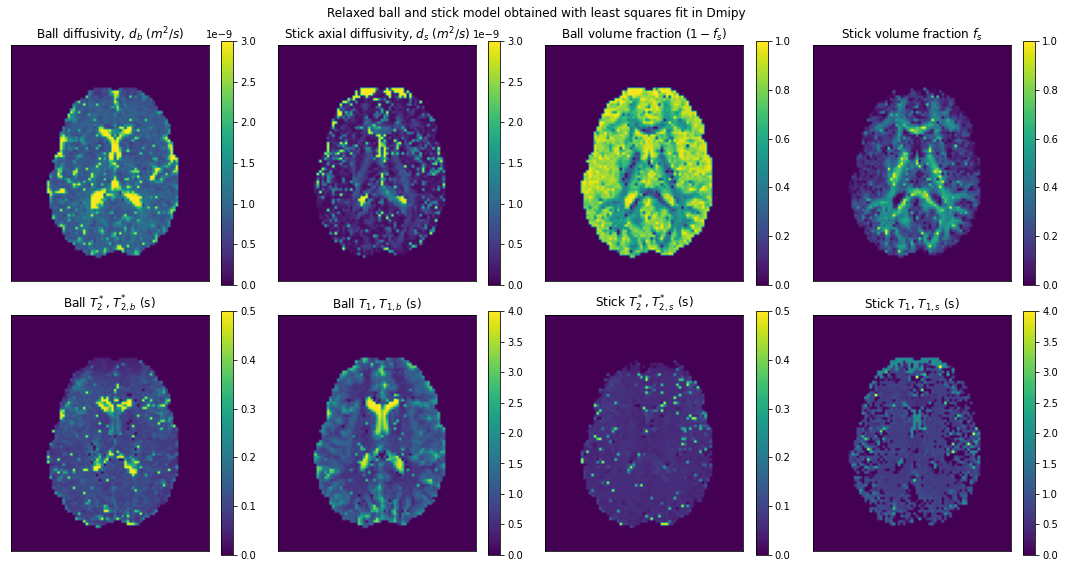

In [4]:
"""Create microstructure maps for each parameter"""

import matplotlib.pyplot as plt
import math

fig, ((ax1, ax6, ax9, ax10), (ax2, ax3, ax7, ax8)) = plt.subplots(nrows=2, ncols=4, figsize=(15,8))

im1 = ax1.imshow(np.rot90(relaxed_ball_diff[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=3e-9)
ax1.set_title("Ball diffusivity, $d_b$ $(m^2/s)$") # G1BallRelaxed_1_lambda_iso
ax1.set_xticks([])
ax1.set_yticks([])
fig.colorbar(im1, ax=ax1)

im6 = ax6.imshow(np.rot90(relaxed_stick_diff[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=3e-9)
ax6.set_title("Stick axial diffusivity, $d_s$ $(m^2/s)$") # C1StickRelaxed_1_lambda_par
ax6.set_xticks([])
ax6.set_yticks([])
fig.colorbar(im6, ax=ax6)

im9 = ax9.imshow(np.rot90(relaxed_vol_zero[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=1)
ax9.set_title("Ball volume fraction $(1 - f_s)$") # partial_volume_0
ax9.set_xticks([])
ax9.set_yticks([])
fig.colorbar(im9, ax=ax9)

im10 = ax10.imshow(np.rot90(relaxed_vol_one[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=1)
ax10.set_title("Stick volume fraction $f_s$") # partial_volume_1
ax10.set_xticks([])
ax10.set_yticks([])
fig.colorbar(im10, ax=ax10)

im2 = ax2.imshow(np.rot90(relaxed_t2_ball[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=0.5)
ax2.set_title("Ball $T_{2}^*$, $T_{2,b}^{*}$ (s)") # G1BallRelaxed_1_t2
ax2.set_xticks([])
ax2.set_yticks([])
fig.colorbar(im2, ax=ax2)

im3 = ax3.imshow(np.rot90(relaxed_t1_ball[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=4)
ax3.set_title("Ball $T_{1}$, $T_{1,b}$ (s)") # G1BallRelaxed_1_t1
ax3.set_xticks([])
ax3.set_yticks([])
fig.colorbar(im3, ax=ax3)

im7 = ax7.imshow(np.rot90(relaxed_t2_stick[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=0.5)
ax7.set_title("Stick $T_{2}^*$, $T_{2,s}^{*}$ (s)") # C1StickRelaxed_1_t2
ax7.set_xticks([])
ax7.set_yticks([])
fig.colorbar(im7, ax=ax7)

im8 = ax8.imshow(np.rot90(relaxed_t1_stick[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=4)
ax8.set_title("Stick $T_{1}$, $T_{1,s}$ (s)")  # C1StickRelaxed_1_t1
ax8.set_xticks([])
ax8.set_yticks([])
fig.colorbar(im8, ax=ax8)

fig.suptitle('Relaxed ball and stick model obtained with least squares fit in Dmipy')

fig.tight_layout()

plt.savefig("figure2.png", dpi=600)

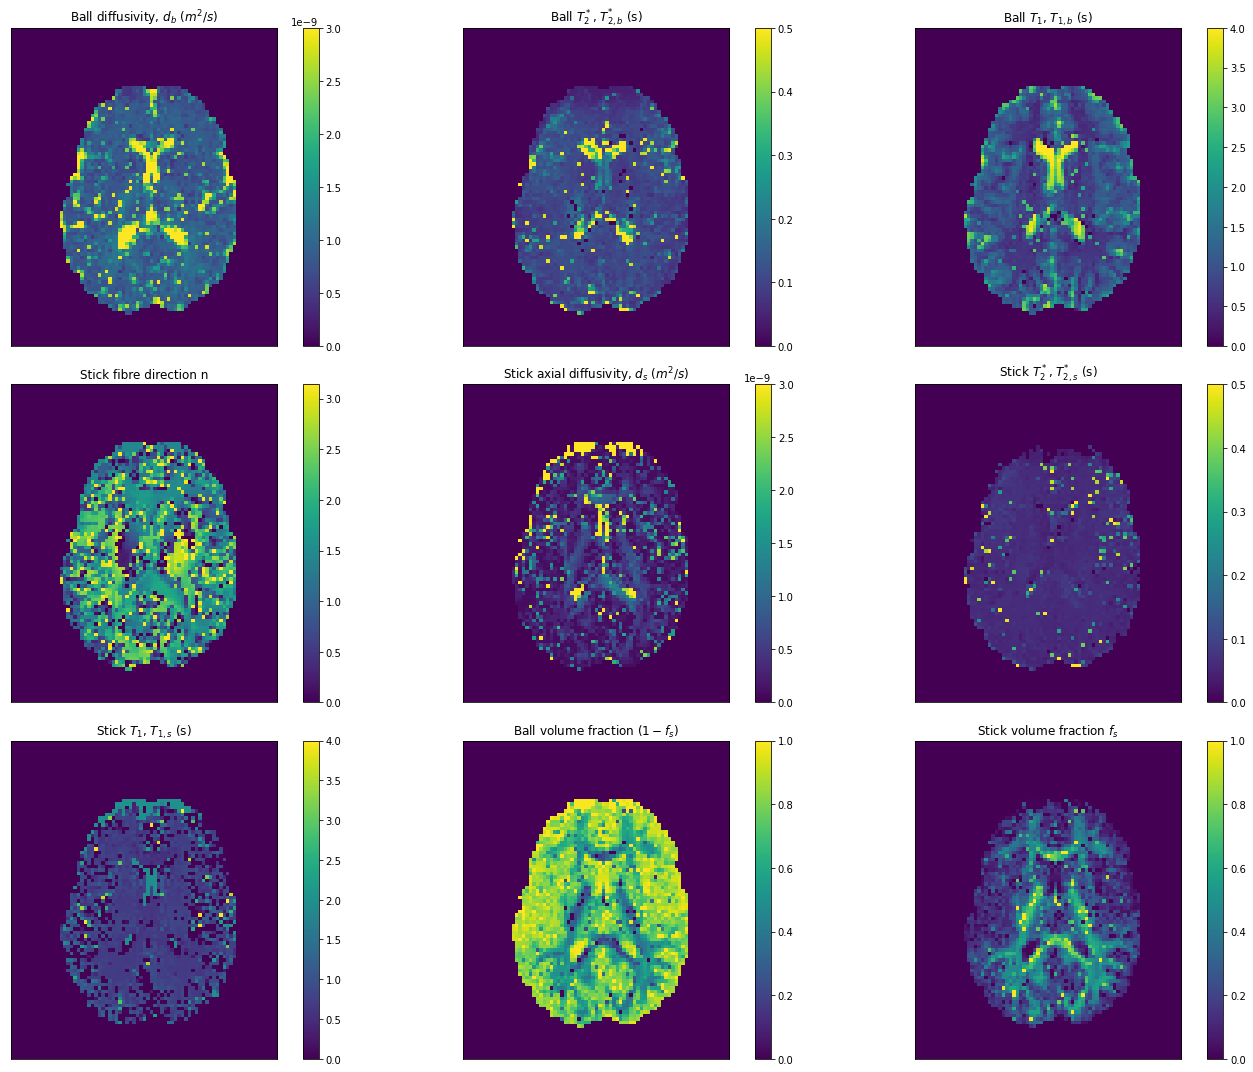

In [6]:
import math
import matplotlib.pyplot as plt
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(20,15))

im1 = ax1.imshow(np.rot90(relaxed_ball_diff[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=3e-9)
ax1.set_title("Ball diffusivity, $d_b$ $(m^2/s)$") # G1BallRelaxed_1_lambda_iso
ax1.set_xticks([])
ax1.set_yticks([])
fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(np.rot90(relaxed_t2_ball[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=0.5)
ax2.set_title("Ball $T_{2}^*$, $T_{2,b}^{*}$ (s)") # G1BallRelaxed_1_t2
ax2.set_xticks([])
ax2.set_yticks([])
fig.colorbar(im2, ax=ax2)

im3 = ax3.imshow(np.rot90(relaxed_t1_ball[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=4)
ax3.set_title("Ball $T_{1}$, $T_{1,b}$ (s)") # G1BallRelaxed_1_t1
ax3.set_xticks([])
ax3.set_yticks([])
fig.colorbar(im3, ax=ax3)

im4 = ax4.imshow(np.rot90(relaxed_stick_direction[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=math.pi)
ax4.set_title("Stick fibre direction n") # C1StickRelaxed_1_mu
ax4.set_xticks([])
ax4.set_yticks([])
fig.colorbar(im4, ax=ax4)

im5 = ax5.imshow(np.rot90(relaxed_stick_diff[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=3e-9)
ax5.set_title("Stick axial diffusivity, $d_s$ $(m^2/s)$") # C1StickRelaxed_1_lambda_par
ax5.set_xticks([])
ax5.set_yticks([])
fig.colorbar(im5, ax=ax5)

im6 = ax6.imshow(np.rot90(relaxed_t2_stick[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=0.5)
ax6.set_title("Stick $T_{2}^*$, $T_{2,s}^{*}$ (s)") # C1StickRelaxed_1_t2
ax6.set_xticks([])
ax6.set_yticks([])
fig.colorbar(im6, ax=ax6)

im7 = ax7.imshow(np.rot90(relaxed_t1_stick[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=4)
ax7.set_title("Stick $T_{1}$, $T_{1,s}$ (s)")  # C1StickRelaxed_1_t1
ax7.set_xticks([])
ax7.set_yticks([])
fig.colorbar(im7, ax=ax7)

im8 = ax8.imshow(np.rot90(relaxed_vol_zero[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=1)
ax8.set_title("Ball volume fraction $(1 - f_s)$") # partial_volume_0
ax8.set_xticks([])
ax8.set_yticks([])
fig.colorbar(im8, ax=ax8)

im9 = ax9.imshow(np.rot90(relaxed_vol_one[:,:,0]*mask_data[:,:,30]), vmin=0, vmax=1)
ax9.set_title("Stick volume fraction $f_s$") # partial_volume_1
ax9.set_xticks([])
ax9.set_yticks([])
fig.colorbar(im9, ax=ax9)

fig.tight_layout()